In [2]:
from evds import evdsAPI
import pandas as pd
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

True

In [ ]:
# GENEL PROJE NOTLARI

# 1-) EVDS’te ilgili serileri indirdikten sonra gecikme etkileri
# (lag) ekleyerek regresyon ya da VAR tarzı modellerle denenmelidir.

In [22]:
# EVDS Data Analysis
# Economic Data Service API analysis for USD and EUR exchange rates

# Get API key from environment variable
api_key = os.getenv('EVDS_API_KEY')
if not api_key:
    raise ValueError("EVDS_API_KEY not found in environment variables")

# Initialize EVDS API
evds = evdsAPI(api_key)

# Get USD and EUR exchange rate data
data = evds.get_data(['TP.DK.USD.A.YTL','TP.DK.EUR.A.YTL'], 
                     startdate="01-01-2019", 
                     enddate="31-12-2019")

issiszlik_data = evds.get_data(['TP.ISGUCARSIV.G7'], # Bu veri 2021 den sonra mevcut değil.
                     startdate="01-01-2012", 
                     enddate="31-12-2019")

print("\nFirst 5 rows:")
print("Data shape:", issiszlik_data.shape)
print("Issiszlik data shape:\n ", issiszlik_data.head(), "\n", issiszlik_data.tail())
print("Data shape:", data.shape)
print("Dolar Euro shape:\n " ,data.head(), "\n", data.tail())



First 5 rows:
Data shape: (96, 2)
Issiszlik data shape:
      Tarih  TP_ISGUCARSIV_G7
0  2012-1               9.3
1  2012-2               9.6
2  2012-3               9.1
3  2012-4               8.2
4  2012-5               7.6 
       Tarih  TP_ISGUCARSIV_G7
91   2019-8              14.0
92   2019-9              13.8
93  2019-10              13.4
94  2019-11              13.3
95  2019-12              13.7
Data shape: (365, 3)
Dolar Euro shape:
          Tarih  TP_DK_USD_A_YTL  TP_DK_EUR_A_YTL
0  01-01-2019              NaN              NaN
1  02-01-2019           5.2810           6.0422
2  03-01-2019           5.3316           6.1061
3  04-01-2019           5.4588           6.2057
4  05-01-2019              NaN              NaN 
           Tarih  TP_DK_USD_A_YTL  TP_DK_EUR_A_YTL
360  27-12-2019           5.9302           6.5759
361  28-12-2019              NaN              NaN
362  29-12-2019              NaN              NaN
363  30-12-2019           5.9370           6.6117
364  31-12

In [5]:
print(data.isna().sum()) # Tatil günleri ve hafta sonu tatilleri boş veriler ile dolu.

# En mantıklı doldurma yöntemi forward fill, backward fill olacak.

data_ffill = data.ffill() 
data_completed = data_ffill.bfill()

print(data_completed.isna().sum())

nan_usd = data[data['TP_DK_USD_A_YTL'].isna()]

print(nan_usd)


Tarih                0
TP_DK_USD_A_YTL    117
TP_DK_EUR_A_YTL    117
dtype: int64
Tarih              0
TP_DK_USD_A_YTL    0
TP_DK_EUR_A_YTL    0
dtype: int64
          Tarih  TP_DK_USD_A_YTL  TP_DK_EUR_A_YTL
0    01-01-2019              NaN              NaN
4    05-01-2019              NaN              NaN
5    06-01-2019              NaN              NaN
11   12-01-2019              NaN              NaN
12   13-01-2019              NaN              NaN
..          ...              ...              ...
354  21-12-2019              NaN              NaN
355  22-12-2019              NaN              NaN
361  28-12-2019              NaN              NaN
362  29-12-2019              NaN              NaN
365  01-01-2020              NaN              NaN

[117 rows x 3 columns]


<Figure size 640x480 with 0 Axes>

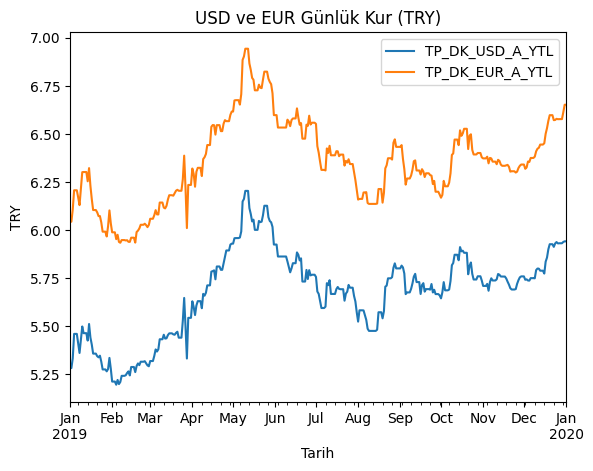

In [6]:
# We will plot the correct graphs to see the relationship between the variables.

data_completed['Tarih'] = pd.to_datetime(data_completed['Tarih'], dayfirst=True, format='%d-%m-%Y')
data_completed = data_completed.set_index('Tarih').sort_index()

# 3) USD & EUR kuru grafiği
plt.figure()
data_completed[['TP_DK_USD_A_YTL', 'TP_DK_EUR_A_YTL']].plot()
plt.title('USD ve EUR Günlük Kur (TRY)')
plt.xlabel('Tarih')
plt.ylabel('TRY')
plt.show()

In [7]:
# NPL ORANLARI İÇİN DATA ANALİZİ

# TP.PFVPBI09.K4 -> Aylık, Bankacılık Sektörü ve TMSF’ye Devrolunan Tasfiye Olunacak Alacaklar (Bin TL) (Arşiv)(Aylık)

# TP.KREDI.L002 -> Krediler - Bankacılık Sektörü (Bin TL) (Arşiv)(Haftalık).

In [21]:
npl_oran_df = evds.get_data(
    ['TP.PFVPBI09.K4',        # Tasfiye Olunacak Alacaklar  (PAY)
     'TP.KREDI.L002'],        # Toplam Nakdî Krediler       (PAYDA)
    startdate="01-01-2012",
    enddate="31-12-2019"
)

# 2) Kolon adlarını kısalt (isteğe bağlı)
npl_oran_df = npl_oran_df.rename(columns={
    'TP.PFVPBI09.K4':  'TOA',
    'TP.KREDI.L002':   'KREDI'
})

print(npl_oran_df.columns.tolist())

# 3) NPL oranını hesapla
npl_oran_df['NPL'] = 100 * npl_oran_df['TP_PFVPBI09_K4'] / npl_oran_df['TP_KREDI_L002']

print(npl_oran_df['NPL']) # montly npl rate over 100.

['Tarih', 'TP_PFVPBI09_K4', 'TP_KREDI_L002']
0     3.028747
1     3.061635
2     2.997291
3     2.991300
4     2.975677
        ...   
91    5.193511
92    5.571803
93    5.800205
94    5.904848
95    6.049682
Name: NPL, Length: 96, dtype: float64


## NOW WE WILL VISUALIZE THE NPL PERCANTAGES.

<Figure size 640x480 with 0 Axes>

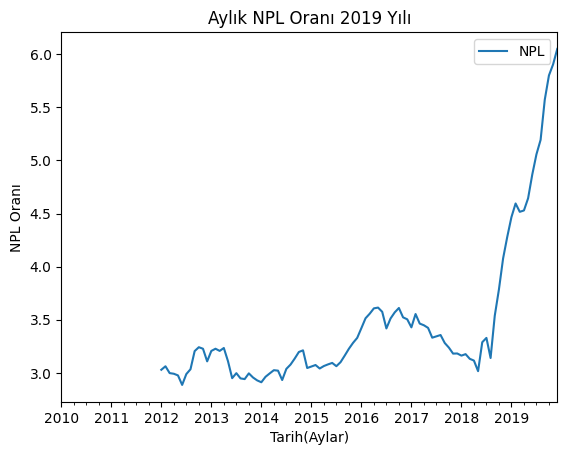

In [20]:
npl_oran_df['Tarih'] = pd.to_datetime(npl_oran_df['Tarih'], dayfirst=True, format='%Y-%m')
npl_oran_df = npl_oran_df.set_index('Tarih').sort_index()

# 3) USD & EUR kuru grafiği
plt.figure()
npl_oran_df[['NPL']].plot()
plt.title('Aylık NPL Oranı 2019 Yılı')
plt.xlabel('Tarih(Aylar)')
plt.ylabel('NPL Oranı')
plt.show()

In [26]:
print(npl_oran_df[['NPL']])
print(issiszlik_data['TP_ISGUCARSIV_G7'])
print(issiszlik_data.columns.tolist())
print(npl_oran_df.columns.tolist())

         NPL
0   3.028747
1   3.061635
2   2.997291
3   2.991300
4   2.975677
..       ...
91  5.193511
92  5.571803
93  5.800205
94  5.904848
95  6.049682

[96 rows x 1 columns]
0      9.3
1      9.6
2      9.1
3      8.2
4      7.6
      ... 
91    14.0
92    13.8
93    13.4
94    13.3
95    13.7
Name: TP_ISGUCARSIV_G7, Length: 96, dtype: float64
['Tarih', 'TP_ISGUCARSIV_G7']
['Tarih', 'TP_PFVPBI09_K4', 'TP_KREDI_L002', 'NPL']


In [29]:
npl_oran_df['Tarih']     = pd.to_datetime(npl_oran_df['Tarih'])
issiszlik_data['Tarih']  = pd.to_datetime(issiszlik_data['Tarih'])
npl_oran    = npl_oran_df.set_index('Tarih').sort_index()
issizlik    = issiszlik_data.set_index('Tarih').sort_index()

# ortak dönemi kesiştir
ortak       = npl_oran.join(issizlik, how='inner')

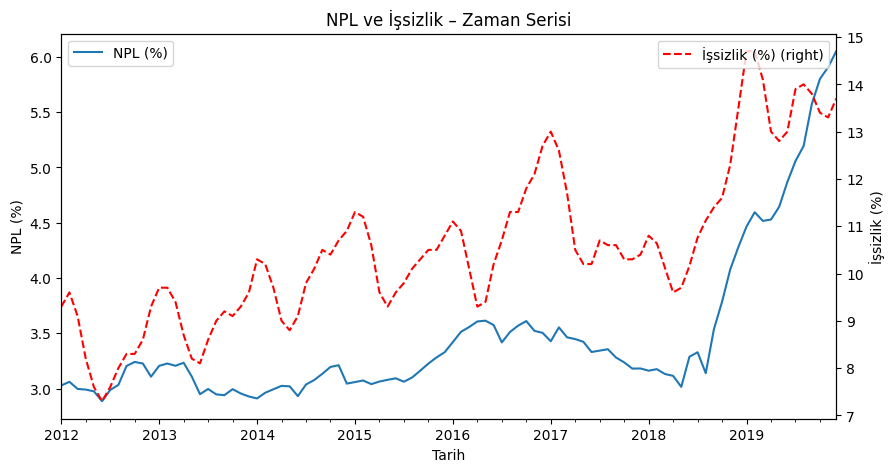

In [30]:
ax = ortak['NPL'].plot(figsize=(10,5), label='NPL (%)')
ortak['TP_ISGUCARSIV_G7'].plot(ax=ax, secondary_y=True,
                               label='İşsizlik (%)', style='r--')

ax.set_title('NPL ve İşsizlik – Zaman Serisi')
ax.set_xlabel('Tarih')
ax.set_ylabel('NPL (%)')
ax.right_ax.set_ylabel('İşsizlik (%)')
ax.legend(loc='upper left')
ax.right_ax.legend(loc='upper right')
plt.show()

In [31]:
corr = ortak[['NPL', 'TP_ISGUCARSIV_G7']].corr().iloc[0,1]
print(f"Pearson korelasyonu: {corr:.3f}")

Pearson korelasyonu: 0.791
